# Titanic Data Investigation#

_ by [Jens Laufer](mailto:jenslaufer@gmail.com) _

12 January 2017

## Introduction

The Titanic was a british passenger line that sunk on his maiden voyage on 15 April 1912. 

At about 11 pm on Sunday 14 April 1912, the ship hit an iceberg and and sank about 2.5 hours later with the loss of almost 1500 lives. One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. 

Although tragedy was not the largest in history the disaster still fascinates the people today. This is due the fact that the ship was the largest and most luxurios ever build and the shipbuilder claimed before that the ship is unsinkable. The wreck of the ship couldn't be found till 1985 and lies in 12,000 feet (3,700 m) below the surface. [1]

Within this investigation I am using a dataset, I downloaded from [Kaggle](https://www.kaggle.com/mrisdal/titanic/exploring-survival-on-the-titanic). The dataset of study contains demographics and passenger information from 891 of the 2224 passengers and crew on board the Titanic. Based on the dataset I am trying to answer serveral questions.

## Questions on data ##

   - Was it more likely to survive as woman or a child?
   - Was ist more likely to survive as first class passenger, because of the socioeconomic status?
   - Was ist more likely to survive on the different locations of embarkment?
   - Was ist more like to survive as a family member or a person on his own?   
   - Was ist more like to survive in certain Age groups?   

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.stats.api as sms
from scipy import stats

filename = 'titanic-data.csv'
titanic_df = pd.read_csv(filename)

## About the dataset ##

### Structure of dataset ###

|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked
|-|-|-|-|-|-|-|-|-|-|-|
|Passenger Id|Survival (0 = No; 1 = Yes)|Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)|Name|Sex|Age|Number of Siblings/Spouses Aboard|Number of Parents/Children Aboard|Ticket Number|Passenger Fare|Cabin|Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

#### Example data ####

In [6]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


##  Data Analysis: Data Cleaning and Wrangling ##

In [7]:
titanic_df.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

I found out that data is missing in some columns:

Not for all passengers the 'Age' is available

Not for all passengers 'Cabin' available.

Not for all passengers 'Embarked' is available.

### Dealing with missing Age

I am filling the missing ages with the mean age of the passenger's class and gender.

In [8]:
# we add the mean of the Age for all missing ages
def fill_na_ages(row):
    age = row['Age']
    sex = row['Sex']
    p_class = row['Pclass']
    if age != age:
        return titanic_df.groupby(['Sex','Pclass'])['Age'].mean()[sex, p_class]
    else:
        return age

titanic_df['Age'] = titanic_df.apply(fill_na_ages, axis=1)

### Dealing with missing Cabin Data

I am not interested in the exact cabin passengers stayed in, I am rather interested on which deck they had been on the ship.
The first letter of the cabin indicates the deck the cabin was on. I am extracting this deck information and creating a new dataset with just the deck for each passenger the deck is available for. I am using a second dataset as there are much less cabin/deck entries than for other fields in the main dataset. Therefore I want to seperate it from the main dataset. 

In [9]:
def get_deck(cabin):
    if cabin == cabin:
        return cabin[0:1]
    return cabin
deck_titanic_df = pd.DataFrame(titanic_df['PassengerId'])
deck_titanic_df['Deck'] = titanic_df.Cabin.apply(get_deck)
deck_titanic_df = deck_titanic_df.dropna(subset=['Deck'])

In [10]:
deck_titanic_df.groupby('Deck').Deck.count()

Deck
A    15
B    47
C    59
D    33
E    32
F    13
G     4
T     1
Name: Deck, dtype: int64

In [11]:
deck_titanic_df.merge(titanic_df, on='PassengerId', how='inner')[deck_titanic_df.merge(titanic_df, on='PassengerId', how='inner').Deck == 'T']

,PassengerId,Deck,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
78,340,T,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S


There might be a problem with the decks, as there is just one entry for deck 'T'.

I researched the web and found out that the Cabin 'T' was the boat deck. There was only one single first class cabin on this deck next to the lifeboats. This cabins seems a very special cabin so I am deleting it.

[Titanic Cabins](https://www.encyclopedia-titanica.org/cabins.html)

In [12]:
deck_titanic_df = deck_titanic_df[deck_titanic_df.Deck != 'T']

### Dealing with missing Embarkments

I am checking where embarkment is missing:

In [13]:
titanic_df[titanic_df.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


I am checking if there are other passengers with either the same ticket or the same cabin:

In [14]:
titanic_df[titanic_df.Embarked.notnull() & ((titanic_df.Cabin == 'B28') | (titanic_df.Ticket == '113572'))]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


Accidently I could not find more passengers with the same ticket or the same cabin.
As the name of the passengers sound English they most probably either boarded in Southampton or Queenstown.

In [15]:
titanic_df[(titanic_df.Embarked == 'S') | (titanic_df.Embarked == 'Q')].groupby('Embarked')['Embarked'].count()

Embarked
Q     77
S    644
Name: Embarked, dtype: int64

As many more passengers boarded in Southampton rather than in Queenstown chances are quiet high these people boarded in Southampton

Researching the web I found this:

[Stone, Mrs. George Nelson (Martha Evelyn)](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html) boarded in Southampton.

[Icard, Miss. Amelie](https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html) boarded in Southampton.

We change the Embarked to 'S' for these tow passengers.

In [16]:
titanic_df.set_value(61, 'Embarked', 'S')
titanic_df.set_value(829, 'Embarked', 'S')
titanic_df[titanic_df.Embarked.notnull() & ((titanic_df.Cabin == 'B28') | (titanic_df.Ticket == '113572'))]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,S
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,S


### Removal of unused columns

I am removing the columns 'Name', 'Ticket', 'Cabin' and 'Fare'  as I do not need them to answer my questions.

I am extracting a new field 'IsFamilyMember' that indicates, if someone is a family member based on the 'Parch'  and 'SibSp'. I am removing those two fields afterwards.

I am extracting different age groups and put the result into a new field 'AgeGroups' and remove the 'Age' column afterwards.

For convenience I am also adding a new column 'IsChild' although the information is also available in 'AgeGroups'

In [17]:
del titanic_df['Name']
del titanic_df['Ticket']
del titanic_df['Fare']
del titanic_df['Cabin']

I change the embarkement location to a full name:

In [18]:
def get_embarked_fullname(row):
    embarked = row['Embarked']
    if embarked == 'S':
        return 'Southampton'
    elif embarked == 'C':
        return 'Cherbourg'
    elif embarked == 'Q':
        return 'Queenstown'
    else:
        return embarked
    
# I add a new column to the dataset
titanic_df['Embarked'] = titanic_df.apply(get_embarked_fullname, axis=1)

We define a new column 'IsFamily' member: A passenger is a family member if either SibSp or Parch is > 0

In [19]:
def is_family_member(row):
    return not(row['Parch'] == 0 and row['SibSp'] == 0)

# I add a new column to the dataset
titanic_df['IsFamilyMember'] = titanic_df.apply(is_family_member, axis=1)

# I remove the Parch and SibSp columns
del titanic_df['Parch']
del titanic_df['SibSp']

I extract different age groups

In [20]:
def age_group(row):
    age = row['Age']
    if age < 1:
        return 'Infant'
    elif age >= 1 and age <= 9:
        return 'Child'
    elif age > 9 and age <= 19:
        return 'Adolescent'
    elif age > 19 and age <= 45:
        return 'Adult'
    elif age > 45 and age <= 60:
        return 'Middle Age'
    elif age > 60:
        return 'Senior'
    else:
        return age

titanic_df['AgeGroup'] = titanic_df.apply(age_group, axis=1)

I extract as well, if a passenger is a child:

In [21]:
def is_child(row):
    age = row['Age']
    if age <= 14:
        return True
    elif age > 14:
        return False
    else:
        return age

titanic_df['IsChild'] = titanic_df.apply(is_child, axis=1)

In [22]:
# I delete the Age column
del titanic_df['Age']

#### Wrangled Data ####

In [23]:
titanic_df.count()

PassengerId       891
Survived          891
Pclass            891
Sex               891
Embarked          891
IsFamilyMember    891
AgeGroup          891
IsChild           891
dtype: int64

In [24]:
titanic_df.head()

,PassengerId,Survived,Pclass,Sex,Embarked,IsFamilyMember,AgeGroup,IsChild
0,1,0,3,male,Southampton,True,Adult,False
1,2,1,1,female,Cherbourg,True,Adult,False
2,3,1,3,female,Southampton,False,Adult,False
3,4,1,1,female,Southampton,True,Adult,False
4,5,0,3,male,Southampton,False,Adult,False


In [61]:
deck_titanic_df.count()

PassengerId    203
Deck           203
dtype: int64

In [62]:
deck_titanic_df.head()

,PassengerId,Deck
1,2,C
3,4,C
6,7,E
10,11,G
11,12,C


## Data Analysis: Answering the questions ##

** Survival Probability of all passengers in the dataset: **

In [26]:
titanic_df['Survived'].mean()

0.3838383838383838

###  Was it more likely to survive as a woman or a child? ###

#### Hypothesis

$H_0$: Gender does not have an impact on the survival probabilty


$H_A$: Gender does have an impact on the survival probabilty

I chose $\alpha = .05$

#### Hypothesis Test

In [27]:
table = pd.crosstab([titanic_df['Survived']], [titanic_df['Sex']])
chi2, p, dof, expected = stats.chi2_contingency(table.values)

print chi2
print p

260.717020167
1.19735706278e-58


$\chi^2 = 260.717020167$

$p = 1.19735706278e-58$

I reject  $H_0$  as p < .0001. Gender has a great impact on the survival probability.

#### Hypothesis

$H_0$: Being a child does not have an impact on the survival probabilty


$H_A$: Being a child does have an impact on the survival probabilty

I chose $\alpha = .05$

##### Hyphothesis Test

In [28]:
table = pd.crosstab([titanic_df['Survived']], titanic_df['IsChild'])
chi2, p, dof, expected = stats.chi2_contingency(table.values)

print chi2
print p

13.4239115317
0.00024843712818


$\chi^2 = 13.4239115317$

$p = 0.00024843712818$

I reject $H_0$ as p < .001. Being a child has an impact on the survival probability.

Survival rate by sex:

In [29]:
titanic_df.groupby('Sex').Survived.mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

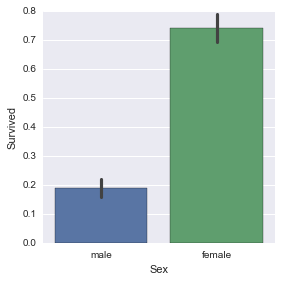

In [30]:
%matplotlib inline
sns.factorplot(x = 'Sex', y = 'Survived', data = titanic_df, kind = 'bar')

The survival probability of the female passengers (74.2%) in the dataset is higher than the overall survival rate (38.4%) and higher than the survival rate of the male passengers (18.9%). 

In [31]:
titanic_df.groupby('IsChild')['Survived'].mean()

IsChild
False    0.364865
True     0.584416
Name: Survived, dtype: float64

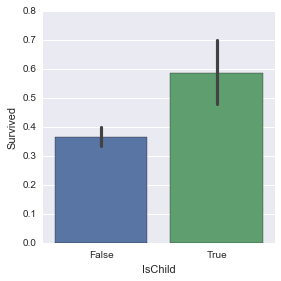

In [32]:
%matplotlib inline
sns.factorplot(x = 'IsChild', y = 'Survived', data = titanic_df, kind = 'bar')

The survival probability of children (58.4%) was higher than the rest of the passengers (38.4%) and the overall survival rate(38.4%).

#### Result ####

On the Titanic existed most probably a ["Women and children first" code of conduct](https://en.wikipedia.org/wiki/Women_and_children_first) when the ship was evacuated as the survival probability was higher for woman and children.

### Was ist more likely to survive as first class passenger, because of the socioeconomic status? ###

Survival rate by passenger class

In [33]:
titanic_df.groupby('Pclass')['Survived'].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

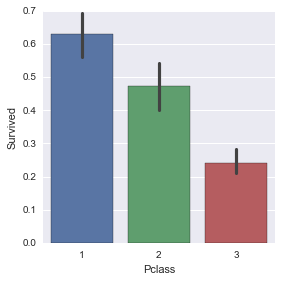

In [34]:
%matplotlib inline
sns.factorplot(x = 'Pclass', y ='Survived', data = titanic_df, kind = 'bar')

The survival probabilty is higher for the second and third class.

Were the first class passengers rescued, because of their socioeconomic status or were other factors responsible for the higher survival probability?

   * Have the first class cabins been on top of the ship and were the passengers of these cabins rescued first?
   * Have there been more female passengers or children in the first class?

#### Have the first class cabins been on top of the ship and were the passengers of these cabins rescued first?

##### Where are the cabins of each passenger class located?

###### Titanic deck layout

![Titanic deck layout](https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Titanic_cutaway_diagram.png/400px-Titanic_cutaway_diagram.png "Titanic deck layout")

In [35]:
merged = deck_titanic_df.merge(titanic_df, on=['PassengerId'], how='inner')[['Deck', 'Survived', 'Pclass', 'Sex']]

In [36]:
merged.groupby(['Pclass']).Survived.count()

Pclass
1    175
2     16
3     12
Name: Survived, dtype: int64

I will ignore the deck information for the second and third class as there are not enough data available for these classes and the cabins of the first class passengers were located on the decks A-E. With this information I should be able to evaluate, if the ship was rescued in a certain order.

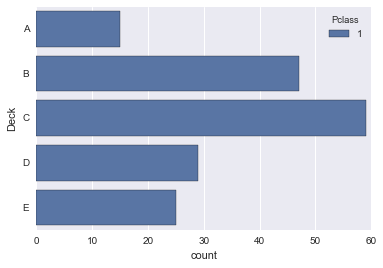

In [37]:
%matplotlib inline
sns.countplot(y="Deck", hue="Pclass", data=merged[merged['Pclass'] == 1].sort_values(by='Deck'))

In [38]:
merged[merged['Pclass'] == 1].groupby(['Pclass','Deck']).Survived.mean().sort_values()

Pclass  Deck
1       A       0.466667
        C       0.593220
        E       0.720000
        B       0.744681
        D       0.758621
Name: Survived, dtype: float64

The cabins of the first class were located on the decks A-E. If there would have been a rescue plan from the top to the bottom there would be a higher survival on deck A than e.g. on deck D. I can actually see that the survival probability on deck D and E was higher than on deck A. On the other hand was survival probabilty on deck B the second highest. It seems that the passengers on top of ship were not rescued first.

In [39]:
titanic_df[titanic_df['Sex'] == "female"].groupby(['Sex', 'Pclass']).Survived.count() / titanic_df.groupby(['Sex']).Survived.count()

Sex     Pclass
female  1         0.299363
        2         0.242038
        3         0.458599
Name: Survived, dtype: float64

In [40]:
titanic_df[titanic_df['IsChild'] == True].groupby(['IsChild','Pclass']).Survived.count() / titanic_df.groupby(['IsChild']).Survived.count()

IsChild  Pclass
True     1         0.064935
         2         0.246753
         3         0.688312
Name: Survived, dtype: float64

The proportion of children and female passengers in the third class was much higher that in the first class.

#### Result ####

The Survival probability of first class passengers was the highest (63.0%). On the other hand the third class had a very low probability of surviving the disaster (24.2%). This is most probably due the fact, that first class passengers where rescued because of their socioeconomic status and not due the fact that there were more children and woman in the first class or that the first class cabins were on the top of the ship and these decks were rescued first.


### Was ist more likely to survive on the different locations of embarkment? ###

#### Hypothesis

$H_0$: Embarkment location does not have an impact on the survival probabilty


$H_A$: Embarkment location does have an impact on the survival probabilty
    

I chose $\alpha = .05$

#### Hypothesis Test

In [41]:
table = pd.crosstab([titanic_df['Survived']], titanic_df['Embarked'])
chi2, p, dof, expected = stats.chi2_contingency(table.values)

print chi2
print p    

25.9644528819
2.30086264814e-06


$\chi^2 = 26.4891498392$

$p = 1.76992228412e-06$

I reject $H_0$ as p < .0001. Embarkment has an impact on the survival probability.

Survival rate by embarkement location:

In [42]:
titanic_df.groupby('Embarked')['Survived'].mean()

Embarked
Cherbourg      0.553571
Queenstown     0.389610
Southampton    0.339009
Name: Survived, dtype: float64

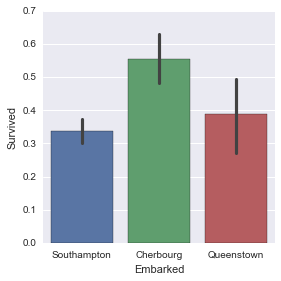

In [43]:
%matplotlib inline
sns.factorplot(x = 'Embarked', y = 'Survived', data = titanic_df, kind = 'bar')

The survival probability was higher for passengers who boarded in Cherbourg.

What factors might be responsible for that:

   - Were there more first class passengers in Cherbourg?
   - Was the proportion of children and woman higher in Cherbourg?

Passengers by embarkment location and class:

In [44]:
titanic_df.groupby(['Embarked','Pclass',]).size() / titanic_df.groupby('Embarked').size()

Embarked     Pclass
Cherbourg    1         0.505952
             2         0.101190
             3         0.392857
Queenstown   1         0.025974
             2         0.038961
             3         0.935065
Southampton  1         0.199690
             2         0.253870
             3         0.546440
dtype: float64

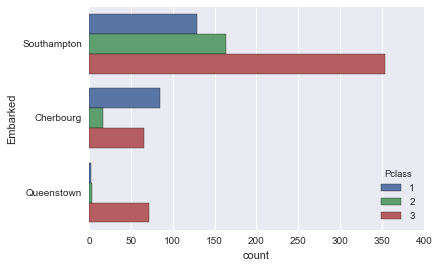

In [45]:
%matplotlib inline
sns.countplot(y="Embarked", hue="Pclass", data=titanic_df)

The proportion of first class passengers was higher in Cherbourg than in Southampton and Queenstown.

In [46]:
titanic_df[titanic_df['IsChild'] == True].groupby(['Embarked','IsChild',]).size() / titanic_df.groupby('Embarked').size()

Embarked     IsChild
Cherbourg    True       0.083333
Queenstown   True       0.051948
Southampton  True       0.091331
dtype: float64

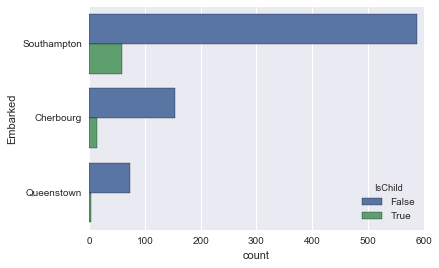

In [47]:
%matplotlib inline
sns.countplot(y="Embarked", hue="IsChild", data=titanic_df)

The proportion of children was about the same in Cherbourg, Queenstown and Southampton

In [48]:
titanic_df[titanic_df.Sex == 'female'].groupby(['Embarked','Sex',]).size() / titanic_df.groupby('Embarked').size()

Embarked     Sex   
Cherbourg    female    0.434524
Queenstown   female    0.467532
Southampton  female    0.317337
dtype: float64

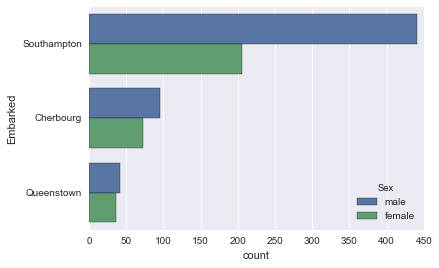

In [49]:
%matplotlib inline
sns.countplot(y="Embarked", hue="Sex", data=titanic_df)

The proportion of woman was about the same in Cherbourg, Queenstown and Southampton

#### Result ####

The probabilty of surviving the titanic disaster was highest in case someone boarded in Cherbourg.
This is most probably due the fact that the proportion of first class passengers from Cherbourg was higher than in Southampton and Queenstown and not due the fact that in Cherborug the propportion of woman or children were higher.

### Was ist more like to survive as a family member or a person on his own? ###

#### Hypothesis

$H_0$: Being a family member does not have an impact on the survival probabilty


$H_A$:  Being a family member does have an impact on the survival probabilty
    

I chose $\alpha = .05$

#### Hypothesis Test

In [50]:
table = pd.crosstab([titanic_df['Survived']], titanic_df['IsFamilyMember'])
chi2, p, dof, expected = stats.chi2_contingency(table.values)

print chi2
print p   

36.0005144677
1.97265438465e-09


$\chi^2 = 36.0005144677$

$p = 1.97265438465e-09$

I reject $H_0$ as p < .0001. Being a family member has an impact on the survival probability.

In [51]:
titanic_df.groupby('IsFamilyMember')['Survived'].mean()

IsFamilyMember
False    0.303538
True     0.505650
Name: Survived, dtype: float64

In [52]:
titanic_df.groupby(['Pclass','IsFamilyMember'])['Survived'].mean()

Pclass  IsFamilyMember
1       False             0.532110
        True              0.728972
2       False             0.346154
        True              0.637500
3       False             0.212963
        True              0.299401
Name: Survived, dtype: float64

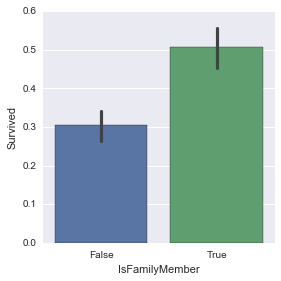

In [53]:
%matplotlib inline
sns.factorplot(x = 'IsFamilyMember', y ='Survived', data = titanic_df, kind = 'bar')

#### Result

The probabilty of surviving the Titanic disaster was higher as member of a family than a person on his own in the first and second class. This is most probably also due the ["Women and children first" code of conduct](https://en.wikipedia.org/wiki/Women_and_children_first). In the third class the chance to survive the titanic disaster for person on his own and a family member was about the same.

### Survival by Age Group

#### Hypothesis

$H_0$: Age Group does not have an impact on the survival probabilty


$H_A$: Age Group does have an impact on the survival probabilty
    

I chose $\alpha = .05$

#### Hypothesis Test

In [54]:
table = pd.crosstab([titanic_df['Survived']], titanic_df['AgeGroup'])
chi2, p, dof, expected = stats.chi2_contingency(table.values)

print chi2
print p   

22.7943350827
0.000369533449617


$\chi^2 = 22.7943350827$

$p = 0.000369533449617$

I reject $H_0$ as p < .001. Age Group has an impact on the survival probability.

In [55]:
titanic_df.groupby('AgeGroup')['Survived'].count().sort_values()

AgeGroup
Infant          7
Senior         22
Child          55
Middle Age     81
Adolescent    102
Adult         624
Name: Survived, dtype: int64

In [56]:
titanic_df.groupby('AgeGroup')['Survived'].mean().sort_values()

AgeGroup
Senior        0.227273
Adult         0.360577
Adolescent    0.401961
Middle Age    0.407407
Child         0.563636
Infant        1.000000
Name: Survived, dtype: float64

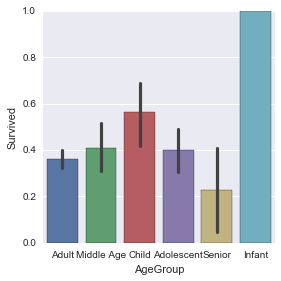

In [57]:
%matplotlib inline
sns.factorplot(x = 'AgeGroup', y ='Survived', data = titanic_df, kind = 'bar')

In [58]:
titanic_df[titanic_df.AgeGroup.isin(['Infant', 'Child'])].groupby(['Pclass', 'AgeGroup']).Survived.count()

Pclass  AgeGroup
1       Child        2
        Infant       1
2       Child       14
        Infant       3
3       Child       39
        Infant       3
Name: Survived, dtype: int64

In [59]:
titanic_df[titanic_df.AgeGroup.isin(['Infant', 'Child'])].groupby(['Pclass', 'AgeGroup']).Survived.mean()

Pclass  AgeGroup
1       Child       0.500000
        Infant      1.000000
2       Child       1.000000
        Infant      1.000000
3       Child       0.410256
        Infant      1.000000
Name: Survived, dtype: float64

#### Result

The probability of surviving the Titanic disaster was higher for children than for other age groups. The lowest chance of surviving the sinking of the ship had adults and seniors. 

Interesting is also that all 7 infants survived the disaster, even the 3 infants from the third class. In the first and second class all children survived apart from one child in the first class. She was Loraine Allison: Loraines parents decided to stay on the ship as Loraines brother was missing with his nurse.[2]

## Appendix A

### Sources

[1] [https://en.wikipedia.org/wiki/RMS_Titanic](https://en.wikipedia.org/wiki/RMS_Titanic)

[2] [https://www.encyclopedia-titanica.org/titanic-victim/loraine-allison.html](https://www.encyclopedia-titanica.org/titanic-victim/loraine-allison.html)